In [20]:
import pandas as pd
import numpy as np
import scipy
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from sklearn import mixture

In [2]:
def csv_to_tensor(csv_path, lag_time = 1, normalize = False):
    """Function to convert csv file to tensor Dataset, required to create data loader
    
    Arguments:
        csv_path (str): Path to csv file 
        lag_time (int): Choosen lag time (to create inputs and targets)
        normalize (bool): normalize data in each column separately (y = (x - x.mean) / x.std) - default True
    """
    #read data form csv
    data = pd.read_csv(csv_path)
    #drop unnecessary columns
    data = data.drop(columns=['time', 'phi', 'psi', 'theta'])
    #normalize columns if required to
    if normalize:
        for col in data:
            data[col] = (data[col] - data[col].mean()) / data[col].std()
    #convert to numpy array
    data_np = data.values
    #create inputs and targets with respect to choosen lag time
    if lag_time == 0:
        x = data_np
        y = data_np
    elif lag_time > 0:
        x = data_np[:-lag_time, :]
        y = data_np[lag_time:, :]
    elif lag_time < 0:
        raise ValueError("Lag time must be non-negative value")
    
    return torch.utils.data.TensorDataset(torch.from_numpy(np.float32(x)), torch.from_numpy(np.float32(y)))

In [3]:
class AE(torch.nn.Module):
    def __init__(self, input_size = 21, lattent_size = 2, hidden_size = [16, 8]):
        super(AE, self).__init__()
        self.sizes = [input_size] + hidden_size + [lattent_size]
        
        #Create all layers for encoder
        for idx, val in enumerate(range(1, len(self.sizes))):
            setattr(self, 'enc%d' % idx, nn.Linear(self.sizes[val - 1], self.sizes[val]))
            
        #Create all layers for decoder
        for idx, val in enumerate(reversed(range(1, len(self.sizes)))):
            setattr(self, 'dec%d' % idx, nn.Linear(self.sizes[val], self.sizes[val - 1]))
    
    def encode(self, x):
        y = x
        for idx in range(len(self.sizes)-2):
            #apply activation layer
            y = F.leaky_relu(getattr(self, 'enc%d' % idx)(y))
        return getattr(self, 'enc%d' % (len(self.sizes)-2))(y)
    
    def decode(self, x):
        y = x
        for idx in range(len(self.sizes)-1):
            #apply activation layer
            y = F.leaky_relu(getattr(self, 'dec%d' % idx)(y))
        return y
    
    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)

In [17]:
#create 6 different datasets with lag_time from 1 to 3 for normalized and unnormalized data
data_dict = {
            'nt1':csv_to_tensor(csv_path='../../ala2_.csv', lag_time = 1, normalize=True),
            'nt2':csv_to_tensor(csv_path='../../ala2_.csv', lag_time = 2, normalize=True),
            'nt3':csv_to_tensor(csv_path='../../ala2_.csv', lag_time = 3, normalize=True),
            'nf1':csv_to_tensor(csv_path='../../ala2_.csv', lag_time = 1, normalize=False),
            'nf2':csv_to_tensor(csv_path='../../ala2_.csv', lag_time = 2, normalize=False),
            'nf3':csv_to_tensor(csv_path='../../ala2_.csv', lag_time = 3, normalize=False)
}  

#create 6 models, each for dataset
models_dict = {
            'nt1':AE(),
            'nt2':AE(),
            'nt3':AE(),
            'nf1':AE(),
            'nf2':AE(),
            'nf3':AE()
} 

In [18]:
#training function
def train(model, train_loader, val_loader, optimizer, loss_fn, epochs):
    loss_list = []
    acc_list = []
    for epoch in range(epochs):
        loss = 0.0
        valid_loss = 0.0
        model.train()
        for inputs, targets in train_loader:
            #reset gradients
            optimizer.zero_grad()
            #compute reconstructions
            outputs = model(inputs)
            #compute a training reconstruction loss
            train_loss = loss_fn(outputs, targets)
            #compute accumulated gradients
            train_loss.backward()
            #update parameters based on current gradients
            optimizer.step()
            #add the batch training loss to epoch loss
            loss += train_loss.item()
        #compute the epoch training loss
        loss = loss/len(train_loader.dataset)
        loss_list.append(loss)
        
        #validation
        model.eval()
        for inputs, targets in val_loader:
            #compute reconstruction
            outputs = model(inputs)
            #compute validation loss
            valid_loss += loss_fn(outputs, targets)
        valid_loss /= len(val_loader.dataset)
        
        acc_list.append(valid_loss)
        #print info
        if epoch % 10 == 9 or epoch == 0:
            print('Epoch {} of {}, training loss = {:.3f}, validation loss = {:.3f}'.format(epoch+1, epochs, loss, valid_loss))
    return loss_list, acc_list

In [19]:
def multi_train(name, data_set, model):
    train_size = int(0.8 * len(data_set))
    val_size = len(data_set) - train_size
    train_d, val_d = random_split(data_set, (train_size, val_size))
    train_data_loader = DataLoader(train_d, batch_size = 128, shuffle=True)
    val_data_loader = DataLoader(val_d, batch_size = 128)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    training_loss, val_loss = train(model, train_data_loader, val_data_loader, optimizer, loss_fn, 100)
#     fig = plt.figure(figsize = (10, 5))
#     if name[1] == 't':
#         plt.title('Normalized, lag time:' + name[-1])
#     else:
#         plt.title('Unnormalized, lag time:' + name[-1])
#     plt.plot(range(len(training_loss)), training_loss, label = 'Training')
#     plt.plot(range(len(val_loss)), val_loss, label = 'Validation')
#     plt.legend()
#     fig.savefig('./res/' + name + '_graph.png', dpi=200)
    
#     out = ae.encode(data_set[:,:][0])
#     out = out.detach().numpy()
#     fig = plt.figure(figsize=(10, 10))
#     if name[1] == 't':
#         plt.title('Normalized, lag time:' + name[-1])
#     else:
#         plt.title('Unnormalized, lag time:' + name[-1])
#     plt.scatter(out[:,0], out[:,1])
#     fig.savefig('./res/' + name + '_scatter.png', dpi=200)
    return training_loss, val_loss

In [20]:
loss_fn = torch.nn.MSELoss(size_average=False)
train_graph = []
val_graph = []
for key in data_dict:
    print(key)
    a, b = multi_train(str(key), data_dict[key], models_dict[key])
    train_graph.append(a)
    val_graph.append(b)

nt1
Epoch 1 of 100, training loss = 17.138, validation loss = 16.170
Epoch 10 of 100, training loss = 11.929, validation loss = 12.018
Epoch 20 of 100, training loss = 11.461, validation loss = 11.624
Epoch 30 of 100, training loss = 11.393, validation loss = 11.582
Epoch 40 of 100, training loss = 11.366, validation loss = 11.572
Epoch 50 of 100, training loss = 11.325, validation loss = 11.499
Epoch 60 of 100, training loss = 11.305, validation loss = 11.528
Epoch 70 of 100, training loss = 11.286, validation loss = 11.474
Epoch 80 of 100, training loss = 11.265, validation loss = 11.460
Epoch 90 of 100, training loss = 11.241, validation loss = 11.439
Epoch 100 of 100, training loss = 11.218, validation loss = 11.414
nt2
Epoch 1 of 100, training loss = 18.007, validation loss = 17.178
Epoch 10 of 100, training loss = 14.251, validation loss = 14.257
Epoch 20 of 100, training loss = 13.773, validation loss = 13.809
Epoch 30 of 100, training loss = 13.742, validation loss = 13.808
Epo

In [23]:
#load raw data
data = pd.read_csv('../../ala2_.csv')

In [ ]:
#prepare data to grouping 
phi = data['phi'].values.reshape(-1, 1)
psi = data['psi'].values.reshape(-1, 1)
X = np.concatenate((phi, psi), axis=1)

#calculate trigonometric functions, because data is periodically
phi_s = np.sin(data['phi'].values.reshape(-1, 1))
phi_c = np.cos(data['phi'].values.reshape(-1, 1))
psi_s = np.sin(data['psi'].values.reshape(-1, 1))
psi_c = np.cos(data['psi'].values.reshape(-1, 1))
X_clus = np.concatenate((phi_s, phi_c, psi_s, psi_c), axis=1)

In [ ]:
#group data to 2 metastabile states 
Y = mixture.BayesianGaussianMixture(
    n_components=2, covariance_type='full', max_iter=100).fit_predict(X_clus)
fig = plt.figure(figsize=(10, 10))
plt.scatter(X[Y==0,0], X[Y==0,1])
plt.scatter(X[Y==1,0], X[Y==1,1])

In [ ]:
#save gropued data to numpy file
np.save('clusters', Y)

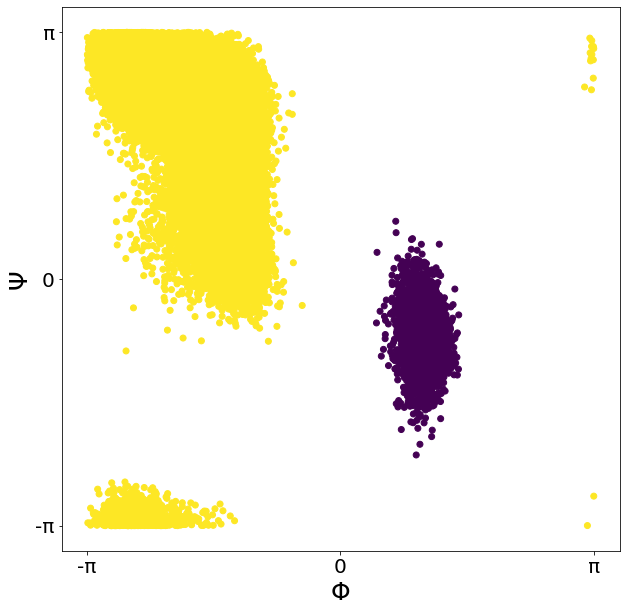

In [348]:
#plot results
Y = np.load('clusters.npy')
fig = plt.figure(figsize=(10, 10))
plt.scatter(data['phi'], data['psi'], c = Y)
plt.xlabel('\u03A6', size=25)
plt.xticks([-np.pi, 0, np.pi], ['-\u03C0', '0', '\u03C0'],size=20)
plt.ylabel('\u03A8', size=25)
plt.yticks([-np.pi, 0, np.pi], ['-\u03C0', '0', '\u03C0'],size=20)
plt.show()
fig.savefig('phipsi.png', dpi=200)

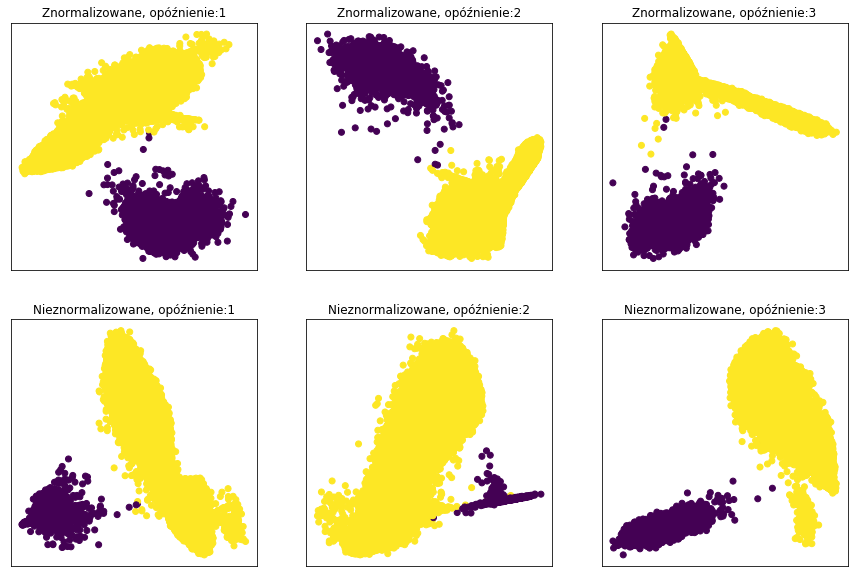

In [337]:
#plot results of TAE with colors from grouping
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, key in enumerate(models_dict):
    lag = i%3+1
    out = models_dict[key].encode(data_dict[key][:,:][0])
    out = out.detach().numpy()
    sub = plt.subplot(2, 3, i+1)
    plt.scatter(out[:,0], out[:,1], c=Y[:-lag])
    plt.xticks([])
    plt.yticks([])
    if key[1] == 't':
        plt.title('Znormalizowane, opóźnienie:' + key[-1])
    else:
        plt.title('Nieznormalizowane, opóźnienie:' + key[-1])
fig.savefig('Clasterized.png', dpi=200)

In [ ]:
# fig1, ax1 = plt.subplots(1, 3, figsize=(18, 5))
# for i, key in enumerate(data_dict):
#     out = models_dict[key].encode(data_dict[key][:,:][0])
#     out = out.detach().numpy()
#     xi = np.linspace(out[:,0].min(), out[:,0].max(), 100)
#     yi = np.linspace(out[:,1].min(), out[:,1].max(), 100)
#     z = np.vstack([xi.flatten(), yi.flatten()])
#     h,_,_ = np.histogram2d(out[:,0], out[:,1], bins=z, density=True)
#     h[h != 0] = -2.479 * np.log(h[h != 0])
#     h = h - h.min()
#     sub1 = plt.subplot(1, 3, i+1)
#     m=plt.imshow(np.flipud(h.T), interpolation='bilinear', vmax=14)
#     plt.xticks([])
#     plt.yticks([])
#     if key[1] == 't':
#         plt.title('Opóźnienie:' + key[-1], size=20)
#     if i == 2:
#         break
        
# cbar=fig1.colorbar(m)
# cbar.set_label('kJ / mol', size=20)
# cbar.ax.set_yticklabels(range(0,15,2),size=15)

        
# plt.subplots_adjust(wspace = 0, hspace = 0)
# fig1.savefig('free_energy')

In [18]:
#calculate free energy surface
def calc_fes(data_x, data_y):
    fig = plt.figure()
    xi = np.linspace(data_x.min(), data_x.max(), 100)
    yi = np.linspace(data_y.min(), data_y.max(), 100)
    z = np.vstack([xi.flatten(), yi.flatten()])
    h,_,_ = np.histogram2d(data_x, data_y, bins=z, density=True)
    h[h != 0] = -2.479 * np.log(h[h != 0])
    h = h - h.min()
    #plt.pcolormesh(xi, yi, h.T, cmap = plt.cm.viridis, vmax=14, shading='gouraud')
    m=plt.imshow(np.flipud(h.T), interpolation='bilinear', vmax=14)
    plt.xticks([])
    plt.yticks([])

    cbar=fig.colorbar(m)
    cbar.set_label('kJ / mol', size=20)
    cbar.ax.set_yticklabels(range(0,15,2), size=15)


    plt.show()
    fig.savefig('reference.png', dpi=200)

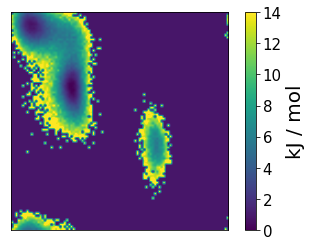

In [19]:
calc_fes(data['phi'], data['psi'])